# LLM Prompting

*The important thing is not to stop questioning. Curiosity has its own reason for existing* - Albert Einstein

We explore how different prompting strategies influence the performance of large language models (LLMs) on the task of financial sentiment classification. We examine **zero-shot**, **few-shot**, and **chain-of-thought (CoT)** prompting techniques using Google's open-source Gemma-3 model deployed locally with Ollama.  Careful design of prompts and enforcement of specific output formats improve the interpretability and reliability of LLM outputs. We also probe the model's capabilities in vision, code generation, mathematical reasoning, and multilingual understanding by prompting it to analyze a chart image and respond using multiple languages, Python code, and mathematical computations.

In [1]:
# By: Terence Lim, 2020-2025 (terence-lim.github.io)
import pandas as pd
from pandas import DataFrame, Series
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import re
import json
from pprint import pprint
import textwrap
from tqdm import tqdm
import ollama

## Sentiment analysis

Sentiment analysis has evolved significantly from its early reliance on lexicon-based methods, which used hand-crafted dictionaries to score sentiment. Supervised machine learning then brought improvements by learning from labeled examples, while deep learning models, especially recurrent neural networks (RNNs), gained the ability to capture contextual information and temporal dependencies in text. Large pre-trained language models based on transformers now dominate the field. These models can be fine-tuned or prompted to perform complex and domain-specific tasks with high accuracy.

### Financial news sentiment

We use a labeled dataset compiled by Malo et al. (2014) containing financial news headlines annotated for sentiment from a retail investor’s perspective. This dataset is hosted on **Kaggle**, a popular platform for sharing machine learning challenges and datasets.

https://www.kaggle.com/datasets/ankurzing/sentiment-analysis-for-financial-news




In [2]:
# Loads financial news headline data labeled with sentiment (positive, neutral, negative)
news = pd.read_csv('assets/all-data.csv',
                   names=["sentiment", "text"],
                   encoding="utf-8",
                   encoding_errors="replace")
news

,sentiment,text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...
...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...
4844,negative,Net sales of the Paper segment decreased to EU...


In [3]:
# Hold out 15 examples in the "training set" that are not used for evaluation
X_train, X_test, y_train, y_test = train_test_split(news['text'], news['sentiment'],
                                                    random_state=0, train_size=15,
                                                    stratify=news['sentiment'])

In [4]:
pd.concat([y_train, X_train], axis=1)

,sentiment,text
2044,neutral,The estimated turnover of the new company is L...
3066,neutral,"On 25 August 2009 , Sampo 's stake in Nordea w..."
331,positive,Finnish investment group Panostaja Oyj said it...
1228,positive,"Furthermore , our fully electrically driven cr..."
3049,neutral,No decision on such sale of the now issued or ...
165,positive,Both operating profit and net sales for the ni...
4803,negative,"UPM-Kymmene Corp. , the world 's largest maker..."
3381,neutral,"The total value of the order , placed by Aspo ..."
1450,neutral,Uponor maintains its full-year guidance for 20...
3484,neutral,`` These developments partly reflect the gover...


In [5]:
targets = ['negative', 'neutral', 'positive']

## Google Gemma 3 model

Google's **Gemma 3** is a collection of lightweight, open models designed for deployment across platforms from mobile devices to workstations. Key technical features include:

- Available in four configurations: 1B, 4B, 12B, and 27B parameters

- Multimodal capabilities: The 4B, 12B, and 27B models support both text and image inputs, while the 1B model is optimized for text-only applications.

- The 1B model supports a 32K-token context window, while the larger models (4B and above) provide a 128K-token context window.

- Multilingual support out-of-the-box for over 35 languages.

https://ai.google.dev/gemma/docs/get_started#models-list

In [4]:
# Model name for Gemma-3-4B model to run locally with Ollama
model_name = "gemma3:12b"

## Structured dialogue

### Prompt engineering 

Instead of explicit training, the model relies on its pre-trained knowledge to interpret and respond to a task based purely on how the prompt is phrased. Rather than modifying the model itself, prompt engineering uses careful wording to guide the model’s behavior. Prompts should clearly explain the task and may specify the expected output format (e.g. JSON) for easier parsing. A well-crafted prompt can significantly improve performance, especially in zero- or few-shot settings.

To improve prompt results, start by assigning an identity to the LLM and sharing relevant background: this helps tailor the tone, detail, and relevance of the response. Be clear about the format you want, such as prose instead of bullet points, tables for comparisons, or timelines when useful. Mention how you'll use the output (e.g., for a class, presentation, or blog post) to influence tone and content. Specify the style or tone you prefer, like persuasive or direct, and clarify whether you're aiming for an essay or a casual post. When asking for rewrites, use specific instructions like "streamline" or "embellish" to guide the changes. Use the LLM to check for missing ideas in your writing, and be iterative with your questions to get more focused answers. For long articles, ask for summaries with a word or time limit. If you're editing your own work, ask to preserve your tone. In technical fields, instruct the model not to simplify or substitute specialized terms. You can also request focused insights or key takeaways. Lastly, to guard against hallucinations, ask for the model’s confidence or sources.

While earlier models required extensive trial and error to find effective prompts, modern instruction-tuned LLMs like DeepSeek-R1 and GPT-4o understand natural language instructions more reliably, reducing the need for manual prompt tuning.






### Structured outputs

LLMs naturally generate free-form text, which can be unpredictable and hard to parse. Structured outputs, such as JSON, enable downstream integration and ensure consistency. Methods for achieving structured output include:
- In-context demonstrations of expected format.
- Function calling / tool use, where the LLM generates function calls.
- Constrained decoding, which enforces valid output formats but requires custom decoders or grammars.

In [7]:
# Extracts a structured JSON response from the LLM's output
def parse_json(s):
    def padding(t):
        if t.count('}') < t.count('{'):
            t += '}'
        if s.count(']') < s.count('['):
            t += ']'
        return t
    s = s.replace("```json", "```")
    s = s.strip()
    s = padding(s)
    try:
        out = json.loads(s[s.index("{"):s.index("}")+1])
        assert "sentiment" in out
    except:
        out = {"sentiment": "neutral", "reasoning": ""}
    return out



### Zero-shot prompt

Zero-shot prompting allows an LLM to perform a task without ay task-specific tuning or examples: just a single instruction and input. The model relies entirely on its pretraining to infer the desired output. 





In [8]:
# Simple, instruction-only prompt asking for a single-word sentiment label in JSON format
def generate_prompt(text):
    return f"""
In one word only, provide the sentiment of the following text as either "positive" or "neutral" or "negative".
Do not provide any other answer.
Provide your output in json format.
Text: '''{text}'''
sentiment:""".strip()
print(generate_prompt(news['text'].iloc[0]))


In one word only, provide the sentiment of the following text as either "positive" or "neutral" or "negative".
Do not provide any other answer.
Provide your output in json format.
Text: '''According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .'''
sentiment:


In [9]:
# Sends prompt to LLaMA3 via Ollama, with temperature=0 for deterministic output
pred0 = []
for i, (text, sentiment) in tqdm(enumerate(zip(X_test, y_test)), total=len(y_test)):
    s = generate_prompt(text)
    output = ollama.generate(model=model_name, prompt=s, options={"temperature":0})
    if i < 5:
        print(f"{sentiment=}: {output['response']}")
        print()
    pred0.append(parse_json(output.response)['sentiment'].lower())


  0%|          | 1/4831 [00:04<6:00:00,  4.47s/it]

sentiment='neutral': ```json
{
  "sentiment": "positive"
}
```



  0%|          | 2/4831 [00:04<2:52:27,  2.14s/it]

sentiment='neutral': ```json
{
  "sentiment": "neutral"
}
```



  0%|          | 4/4831 [00:05<1:11:40,  1.12it/s]

sentiment='negative': ```json
{
  "sentiment": "negative"
}
```

sentiment='positive': neutral



  0%|          | 5/4831 [00:06<1:00:23,  1.33it/s]

sentiment='positive': ```json
{
  "sentiment": "positive"
}
```



100%|██████████| 4831/4831 [33:40<00:00,  2.39it/s]


In [10]:
# Evaluate predictions
print(f"Accuracy: {accuracy_score(y_true=y_test[:len(pred0)], y_pred=pred0):.3f}")
print(classification_report(y_true=y_test[:len(pred0)], y_pred=pred0))
c = confusion_matrix(y_true=y_test[:len(pred0)], y_pred=pred0, labels=targets)
DataFrame(columns=pd.MultiIndex.from_product([['Predicted'], targets]),
          index=targets, data=c)    # display confusion matrix

Accuracy: 0.799
              precision    recall  f1-score   support

    negative       0.77      0.82      0.79       602
     neutral       0.84      0.82      0.83      2870
    positive       0.73      0.73      0.73      1359

    accuracy                           0.80      4831
   macro avg       0.78      0.79      0.79      4831
weighted avg       0.80      0.80      0.80      4831



Predicted                 
          negative neutral positive
negative       493     108        1
neutral        136    2367      367
positive        12     349      998

### In-context learning

**Few-shot prompting**, or **In-Context Learning (ICL)**, enhances performance by including labeled examples directly in the prompt. Instead of fine-tuning (and altering the pretrained neural network weights of) the model with new training examples, the model figures out how to perform well on that task simply by taking a few task-specific examples as input.  

Even when examples are randomly selected, few-shot prompts often outperform zero-shot, as the examples provide additional context. However, the exact choice and order of examples can affect accuracy and variance in responses.


In [8]:
# Creates 15 prompt examples from training set
few_shots = [f"Text: '''{text}'''\nSentiment: {sentiment}"
             for text, sentiment in zip(X_train, y_train)]

# Concatenates few-shot examples before posing a new query
def generate_prompt(text, few_shots=few_shots):
    examples = "\n\n".join(few_shots)
    return f"""
Here are {len(few_shots)} examples of providing the sentiment based on the given text.

{examples}

In one word only, provide the sentiment of the following text as either "positive" or "neutral" or "negative".
Do not provide any other answer.
Text: '''{text}'''
sentiment:""".strip()
print(generate_prompt(news['text'].iloc[0]))


Here are 15 examples of providing the sentiment based on the given text.

Text: '''The estimated turnover of the new company is LVL 2,5 million EEK 40 million .'''
Sentiment: neutral

Text: '''On 25 August 2009 , Sampo 's stake in Nordea was 19.45 % .'''
Sentiment: neutral

Text: '''Finnish investment group Panostaja Oyj said its net profit went up to 8.6 mln euro $ 11.4 mln in fiscal 2005-06 , ended October 31 , 2006 , from 2.8 mln euro $ 3.7 mln in the same period of fiscal 2004-05 .'''
Sentiment: positive

Text: '''Furthermore , our fully electrically driven cranes are environmentally friendly .'''
Sentiment: positive

Text: '''No decision on such sale of the now issued or existing treasury shares to YA Global has been made yet .'''
Sentiment: neutral

Text: '''Both operating profit and net sales for the nine-month period increased , respectively by 26.6 % and 3.4 % , as compared to the corresponding period in 2006 .'''
Sentiment: positive

Text: '''UPM-Kymmene Corp. , the world 's 

In [12]:
# Sends prompt demonstrating the desired response
pred1 = []
for i, (text, sentiment) in tqdm(enumerate(zip(X_test, y_test)), total=len(y_test)):
    s = generate_prompt(text)
    output = ollama.generate(model=model_name, prompt=s, options={"temperature":0})
    if i < 5:
        print(f"{sentiment=}: {output['response']}")
        print()
    pred1.append(output.response.strip().split('\n')[-1].lower())

  0%|          | 0/4831 [00:00<?, ?it/s]

  0%|          | 2/4831 [00:00<27:25,  2.93it/s]

sentiment='neutral': positive

sentiment='neutral': neutral



  0%|          | 4/4831 [00:01<15:20,  5.25it/s]

sentiment='negative': negative

sentiment='positive': neutral



  0%|          | 6/4831 [00:01<11:30,  6.99it/s]

sentiment='positive': neutral



100%|██████████| 4831/4831 [09:20<00:00,  8.61it/s]


In [13]:
# Evaluate predictions
print(f"Accuracy: {accuracy_score(y_true=y_test[:len(pred1)], y_pred=pred1):.3f}")
print(classification_report(y_true=y_test[:len(pred1)], y_pred=pred1))
c = confusion_matrix(y_true=y_test[:len(pred1)], y_pred=pred1, labels=targets)
DataFrame(columns=pd.MultiIndex.from_product([['Predicted'], targets]),
          index=targets, data=c)    # display confusion matrix

Accuracy: 0.814
              precision    recall  f1-score   support

    negative       0.80      0.94      0.86       602
     neutral       0.84      0.85      0.85      2870
    positive       0.76      0.67      0.71      1359

    accuracy                           0.81      4831
   macro avg       0.80      0.82      0.81      4831
weighted avg       0.81      0.81      0.81      4831



Predicted                 
          negative neutral positive
negative       564      37        1
neutral        126    2451      293
positive        14     428      917

### Chain-of-thought (CoT) prompting

**Chain-of-thought (CoT)** prompting encourages LLMs to reason step-by-step before making a final prediction. Instead of jumping to answers, LLMs can be prompted to explain their reasoning step by step. Introduced by Wei et al. (2022), CoT can be paired with few-shot prompts to improve performance on tasks requiring logical inference. By generating intermediate reasoning, the model delays its decision-making, reducing errors and hallucinations. 

Extensions include:
- Self-Consistency: Voting over multiple CoT outputs.
- Tree of Thoughts (ToT): Exploring multiple reasoning paths.
- ReAct: Combining reasoning with tool use.
- Reflexion: Prompting the model to critique and revise its own answers.

In [9]:
# Expands prompt to include step-by-step instructions: extract terms, identify sentiment cues, provide reasoning
def generate_prompt(text, few_shots=few_shots):
    '''Evaluate the financial news by identifying the cause (e.g., earnings report, economic policy, 
market reaction) and its effect on investor sentiment. If the cause indicates positive impact 
on stock prices or economy, classify it as "positive". If it suggests decline or uncertainty, 
classify it as "negative". '''
    examples = "\n\n".join(few_shots)
    return f"""
Here are {len(few_shots)} examples of providing the sentiment based on the given text.

{examples}.

Analyze the financial news headline in a step-by-step manner. 
First, identify key financial terms (e.g., profit, loss, growth, decline).
Second, extract phrases indicating sentiment (e.g., 'strong earnings,' 'market turmoil'). 
Finally, provide a reasoned conclusion and assess whether the sentiment 
is "positive", "negative", or "neutral" from the perspective of retail investors.
If you cannot assess the sentiment, then classify it "neutral". 
Provide your sentiment label and reasoning in json format. 
Do not provide any other answer.
Text: {text}""".strip()

In [10]:
# CoT prompt to induce intermediate reasoning steps
pred2 = []
for i, (text, sentiment) in tqdm(enumerate(zip(X_test, y_test)), total=len(y_test)):
    s = generate_prompt(text)
    output = ollama.generate(model=model_name, prompt=s, options={"temperature":0})
    if i < 5:
        print(f"Labeled {sentiment=}.  RESPONSE=")
        pprint(f"{output.response}")
    pred2.append(parse_json(output.response)['sentiment'].lower())

  0%|          | 1/4831 [00:06<8:53:32,  6.63s/it]

Labeled sentiment='neutral'.  RESPONSE=
('```json\n'
 '{\n'
 '  "sentiment": "neutral",\n'
 '  "reasoning": "The text announces the establishment of a new sales and '
 'marketing group. While this could potentially lead to positive outcomes '
 '(increased sales, market share), the announcement itself is a procedural '
 "change and doesn't inherently convey positive or negative financial news. "
 "It's a statement of action rather than a report of financial performance. "
 'Therefore, from a retail investor\'s perspective, it\'s neutral."\n'
 '}\n'
 '```')


  0%|          | 2/4831 [00:08<5:20:08,  3.98s/it]

Labeled sentiment='neutral'.  RESPONSE=
('```json\n'
 '{\n'
 '  "sentiment": "neutral",\n'
 '  "reasoning": "The text describes a typical order value range. It doesn\'t '
 "express any positive or negative financial performance. It's simply stating "
 'a common value, which is informational rather than indicative of a positive '
 'or negative outcome for investors. Therefore, the sentiment is neutral."\n'
 '}\n'
 '```')


  0%|          | 3/4831 [00:10<4:05:11,  3.05s/it]

Labeled sentiment='negative'.  RESPONSE=
('```json\n'
 '{\n'
 '  "sentiment": "negative",\n'
 '  "reasoning": "The headline explicitly states an \'operating loss\' which '
 "contrasts with a 'profit' in the previous year. The shift from profit to "
 'loss is a clear indicator of negative financial performance. This would '
 'likely be concerning for retail investors."\n'
 '}\n'
 '```')


  0%|          | 4/4831 [00:13<3:59:07,  2.97s/it]

Labeled sentiment='positive'.  RESPONSE=
('```json\n'
 '{\n'
 '  "sentiment": "neutral",\n'
 '  "reasoning": "The text describes a decision made by shareholders regarding '
 'a buyout of minority shares. While a buyout can have implications, the text '
 "itself doesn't express a positive or negative outcome. It's a factual "
 "statement of an action taken. From a retail investor's perspective, it's "
 "information but doesn't inherently signal positive or negative financial "
 'performance. Therefore, the sentiment is classified as neutral."\n'
 '}\n'
 '```')


  0%|          | 5/4831 [00:15<3:39:55,  2.73s/it]

Labeled sentiment='positive'.  RESPONSE=
('```json\n'
 '{\n'
 '  "sentiment": "positive",\n'
 '  "reasoning": "The headline indicates that Raute Corporation has received '
 'orders worth a significant amount (EUR 12 million). Receiving orders is '
 'generally a positive sign for a company, suggesting demand for its products '
 'or services. This is a positive development for retail investors as it '
 'implies potential revenue and growth for the company."\n'
 '}\n'
 '```')


100%|██████████| 4831/4831 [3:26:46<00:00,  2.57s/it]  


In [22]:
# Evaluate prediction
print(f"Accuracy: {accuracy_score(y_true=y_test[:len(pred2)], y_pred=pred2):.3f}")
print(classification_report(y_true=y_test[:len(pred2)], y_pred=pred2))
c = confusion_matrix(y_true=y_test[:len(pred2)], y_pred=pred2, labels=targets)
DataFrame(columns=pd.MultiIndex.from_product([['Predicted'], targets]),
          index=targets, data=c)    # display confusion matrix

Accuracy: 0.829
              precision    recall  f1-score   support

    negative       0.83      0.90      0.86       602
     neutral       0.82      0.91      0.87      2870
    positive       0.85      0.62      0.72      1359

    accuracy                           0.83      4831
   macro avg       0.83      0.81      0.82      4831
weighted avg       0.83      0.83      0.82      4831



Predicted                 
          negative neutral positive
negative       541      59        2
neutral         99    2620      151
positive        10     503      846

## Vision language

The model can be prompted to process both text and image inputs, enabling tasks such as visual question answering and image captioning.

Analyze a chart image, specifically Figure 4 from Malo et al (2014)


(np.float64(-0.5), np.float64(497.5), np.float64(486.5), np.float64(-0.5))

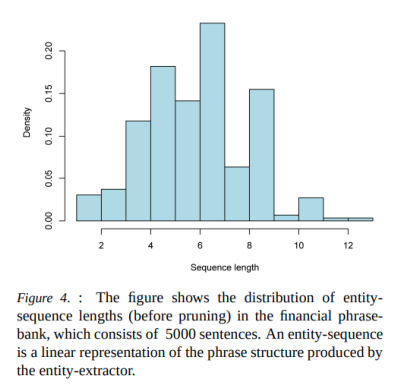

In [2]:
# Load and display a test image
from PIL import Image
import matplotlib.pyplot as plt
image_filename = "assets/MSDTRPL_EC013-H-2020-1602198302.webp"
image_filename = "assets/malo-fig4.png"
image = Image.open(image_filename)
plt.imshow(image)
plt.axis('off')

In [5]:
response = ollama.chat(model=model_name,
	                   messages=[{'role': 'user',
                                  'content': 'Describe this image:',
			                      'images': [image_filename]}])

In [6]:
print("\n".join(textwrap.fill(s) for s in response['message']['content'].split('\n')))

Here's a description of the image you sent:

**Type of Chart:**

The image shows a histogram.

**Data Represented:**

The histogram displays the distribution of "sequence lengths" (likely
referring to the length of entity sequences) from a financial phrase
bank consisting of 5000 sentences. The sequence lengths are
represented before pruning.

**Axes:**

*   **X-axis (Horizontal):** Represents the "Sequence Length," ranging
from 2 to 12, with integer values.
*   **Y-axis (Vertical):** Represents the "Density," ranging from 0 to
0.20.

**Key Observations:**

*   The distribution is somewhat skewed, with a peak around sequence
lengths of 6 and 8.
*   There are a noticeable number of sequences with lengths between 6
and 10.
*   The density decreases as the sequence length moves away from the
peak.

**Overall Impression:**

The histogram provides a visual summary of how long the entity
sequences are, before any pruning or filtering is applied. It suggests
that most sequences are relatively

## Code writing

Prompt the model to generate Python code to reproduce the plot.

Code writing performance can generally be evaluated using software engineering (SWE) benchmarks such as `bigcodebench`

https://github.com/bigcode-project/bigcodebench

In [ ]:
coding = ollama.chat(
    model=model_name,
	messages=[{'role': 'user',
               'content': 'Please write python code to generate this plot:',
			   'images': [image_filename]}])


In [8]:
print(coding['message']['content'])

```python
import matplotlib.pyplot as plt
import numpy as np

# Data for the histogram (based on the image)
sequence_lengths = np.array([2, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 
                            7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 
                            8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 
                            10, 10, 10, 11, 11, 11, 11, 11, 12, 12, 12])

# Calculate the density (frequency / total count)
density = np.zeros_like(sequence_lengths, dtype=float)
total_count = len(sequence_lengths)
for i in range(total_count):
    density[i] = 1 / total_count

# Create the histogram
plt.figure(figsize=(8, 6))  # Adjust figure size for better visualization
plt.hist(sequence_lengths, bins=np.arange(2, 14), density=True, edgecolor='black', alpha=0.7)

# Set labels and title
plt.xlabel("Sequence length")
plt.ylabel("Density")
plt.title("Distribution of Entity-Sequence Lengths")

# Set y-axis limits
plt.ylim

## Mathematical reasoning

Prompt the model to compute a summary statistic of the bar heights, and to show its reasoning.

More rigorous tests of mathematical reasoning can be performed with mathematical problem solving benchmarks such as the MATH dataset, which comprises 12,500 problems from the leading US mathematics competitions that require advanced skills in areas like algebra, calculus, geometry, and statistics.

https://github.com/hendrycks/math/

In [11]:
msg = 'Calculate the logarithmic average of the square root of the bar heights,' +\
      'show your work:'
coding = ollama.chat(
    model=model_name,
	messages=[{'role': 'user', 'content': msg, 'images': [image_filename]}])

In [12]:
print(coding['message']['content'])

Here's how we can calculate the logarithmic average of the square root of the bar heights, along with the steps:

**1. Read the Bar Heights from the Histogram**

From the image, we can estimate the bar heights (density values) for each sequence length.  Let's approximate them as follows:

*   Sequence Length 2: 0.02
*   Sequence Length 4: 0.04
*   Sequence Length 6: 0.06
*   Sequence Length 8: 0.18
*   Sequence Length 10: 0.08
*   Sequence Length 12: 0.02

**2. Calculate the Square Root of Each Bar Height**

Now, we take the square root of each of these density values:

*   √0.02 ≈ 0.141
*   √0.04 ≈ 0.200
*   √0.06 ≈ 0.245
*   √0.18 ≈ 0.424
*   √0.08 ≈ 0.283
*   √0.02 ≈ 0.141

**3. Calculate the Logarithm of Each Square Root**

Next, we take the natural logarithm (ln) of each of the square roots:

*   ln(0.141) ≈ -1.96
*   ln(0.200) ≈ -1.61
*   ln(0.245) ≈ -1.44
*   ln(0.424) ≈ -0.88
*   ln(0.283) ≈ -1.26
*   ln(0.141) ≈ -1.96

**4. Calculate the Arithmetic Mean of the Logarithms**

No

## Multi-lingual

Translate to Mandarin and French

In [15]:
mandarin = ollama.chat(
	model=model_name,
	messages=[
		{
			'role': 'user',
			'content': 'Please translate to mandarin: ' + response['message']['content'],
		}
	]
)

In [16]:

print("\n".join(textwrap.fill(s) for s in mandarin['message']['content'].split('\n')))

Okay, here's a Mandarin translation of the description, aiming for
accuracy and clarity. I've included explanations after each section to
clarify choices and offer alternatives.  I've also provided a more
conversational version at the very end.

**1. Type of Chart:**

* **Mandarin:** 图片显示的是一个直方图。(Pìngtú xiǎnshì de shì yīgè zhítǔtú.)
* **Explanation:**
    * `图片 (pìngtú)`: Image
    * `显示 (xiǎnshì)`: Displays, shows
    * `是 (shì)`: Is (linking verb)
    * `一个 (yīgè)`: A, one
    * `直方图 (zhítǔtú)`: Histogram (standard term)

**2. Data Represented:**

* **Mandarin:** 直方图展示了来自一个包含 5000
句话的金融短语库中的“序列长度”的分布情况。序列长度是在修剪之前的数据。(Zhítǔtú zhǎnshì le láizì yīgè
bāohán 5000 句话的 jīnróng duǎnyǔ kù zhōng de “xùliè chángdù” de fēnbù
qíngkuàng. Xùliè chángdù shì zài xiūjiǎn zhīqián de shùjù.)
* **Explanation:**
    * `展示 (zhǎnshì)`: Shows, presents (more formal than `显示`)
    * `来自 (láizì)`: From
    * `包含 (bāohán)`: Contains, includes
    * `句话 (jùhuà)`: Sentences (literally "sentence-measure word")
   

In [17]:
french = ollama.chat(
	model=model_name,
	messages=[
		{
			'role': 'user',
			'content': 'Please translate to french: ' + response['message']['content'],
		}
	]
)

In [18]:
print("\n".join(textwrap.fill(s) for s in french['message']['content'].split('\n')))

Okay, here's a French translation of the description, aiming for
accuracy and clarity. I've included a couple of options for certain
phrases to give you some flexibility.  I've also added notes after
each section explaining choices made.

**Option 1 (More Formal/Technical):**

Voici une description de l'image que vous avez envoyée :

**Type de graphique :**

L'image présente un histogramme.  *(Straightforward translation)*

**Données représentées :**

L'histogramme illustre la distribution des "longueurs de séquences"
(probablement faisant référence à la longueur des séquences d'entités)
provenant d'une banque de phrases financières composée de 5000
phrases. Les longueurs de séquences sont représentées avant élagage.
*(“Élagage” is a good technical term for pruning)*

**Axes :**

*   **Axe des abscisses (horizontal) :** Représente la "Longueur de
séquence," variant de 2 à 12, avec des valeurs entières. *(“Axe des
abscisses” is the formal term for the x-axis)*
*   **Axe des ordonnées (v

References:

Malo, P., Sinha, A., Takala, P., Korhonen, P. and Wallenius, J. (2014): “Good debt or bad debt: Detecting semantic orientations in economic texts.” Journal of the American Society for Information Science and Technology.

Jason Wei, Xuezhi Wang, Dale Schuurmans, Maarten Bosma, Brian Ichter, Fei Xia, Ed Chi, Quoc Le and Denny Zhou, 2023, Chain-of-Thought Prompting Elicits Reasoning in Large Language Models, https://arxiv.org/abs/2201.11903

Greg Durrett, 2023, "CS388 Natural Language Processing course materisl", retrieved from https://www.cs.utexas.edu/~gdurrett/courses/online-course/materials.html

https://llama.meta.com/docs/how-to-guides/prompting/

https://www.promptingguide.ai/techniques/cot

https://medium.com/age-of-awareness/chain-of-thought-in-ai-7f45c3d2c12a